<a href="https://colab.research.google.com/github/idrtabd/msai-retina-demo/blob/main/RetinaDemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Setup the environment and import the FastAI libraries, this will take a while.
#This will also attempt to connect to your Google Drive
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 63.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 79.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━

In [ ]:
# Import FastAI vision-related libraries
from fastbook import *
from fastai.vision.learner import vision_learner
from fastai.metrics import error_rate
from torchvision.models.resnet import resnet34
from fastai.vision.all import *

In [ ]:
# Get folder/files from google drive with path "msai/Fundus_Scanes_Sorted"
# Your data should have the structure Train, Validation sub folders
from google.colab import drive
drive.mount('/content/drive')
path = Path('/content/drive/MyDrive/MSAI/Fundus_Scanes_Sorted')

Mounted at /content/drive


In [ ]:
# Display the path to ensure it's correctly mounted and list the files in the dataset directory
print(path)
print(path.ls())

/content/drive/MyDrive/MSAI/Fundus_Scanes_Sorted
[Path('/content/drive/MyDrive/MSAI/Fundus_Scanes_Sorted/Train'), Path('/content/drive/MyDrive/MSAI/Fundus_Scanes_Sorted/Validation')]


In [ ]:
#This is the 'default' datablock. The
retina_datablock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),  # Define the types of data: image and category
    get_items=get_image_files,  # Function to get images
    splitter=GrandparentSplitter(train_name='Train', valid_name='Validation'),  # Split dataset (these directories must exist)
    get_y=parent_label,  # Get labels from the parent folder name
    item_tfms=Resize(700),  # Resize images
    batch_tfms=aug_transforms(size=244, min_scale=0.75)
)

In [ ]:
# Load the dataset into a DataLoader for batching
dls = retina_datablock.dataloaders(path)

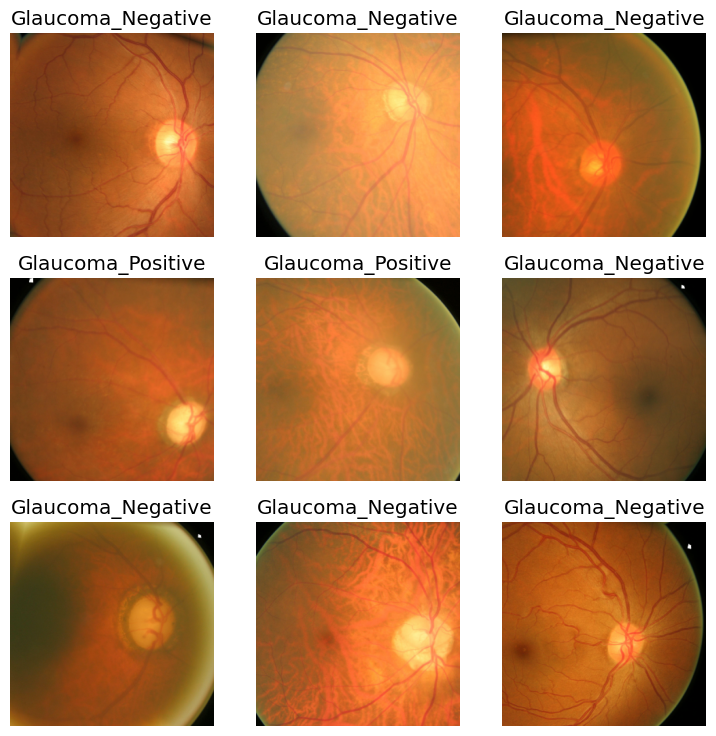

In [ ]:
dls.show_batch()  # Visualize a batch of data


In [ ]:
# Train using ResNet34 architecture and fine-tune with the dataset
learn = vision_learner(dls, resnet34, metrics=error_rate, pretrained=True)
learn.fine_tune(30)

epoch,train_loss,valid_loss,error_rate,time
0,1.190891,0.869233,0.315385,00:19


epoch,train_loss,valid_loss,error_rate,time
0,0.994616,0.680393,0.307692,00:20
1,0.967732,0.754926,0.353846,00:20
2,0.930283,0.905246,0.369231,00:20
3,0.907463,1.026441,0.415385,00:20
4,0.874870,1.114460,0.369231,00:20
5,0.837371,0.887959,0.269231,00:20
6,0.787631,0.988225,0.292308,00:20
7,0.734903,1.013926,0.330769,00:20
8,0.698766,1.014671,0.284615,00:20
9,0.655957,1.353536,0.361538,00:20


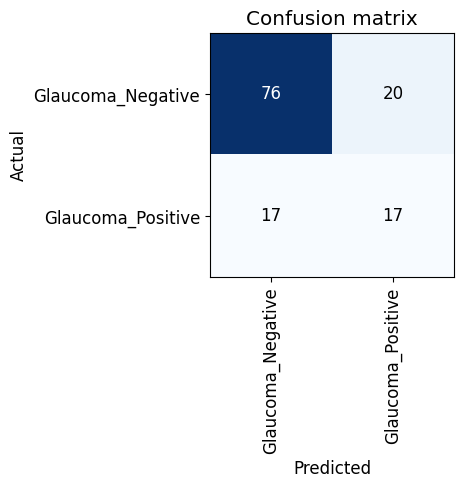

In [ ]:
# Review the model's performance and visualize the confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()  # Plot the confusion matrix

In [ ]:
# Experiment with a second DataBlock configuration, using different augmentations

retina_datablock2 = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='Train', valid_name='Validation'),
    get_y=parent_label,
    item_tfms=Resize(800, method=ResizeMethod.Pad, pad_mode='zeros'),  # Resize images using padding
    batch_tfms=aug_transforms(
        size=200,
        min_scale=0.9,
        max_rotate=60,
        max_lighting=0.2,
        max_zoom=1.5,
        max_warp=0.3,
        p_affine=0.75,
        p_lighting=0.75
    )
)
dls2 = retina_datablock2.dataloaders(path)


In [ ]:
# Load the data with the new configuration and train with ResNet50
# THis is a 'deeper' model
learn2 = vision_learner(dls2, resnet50, metrics=[error_rate, Recall()], pretrained=True)
learn2.fine_tune(20)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 153MB/s]


epoch,train_loss,valid_loss,error_rate,recall_score,time
0,1.325346,1.328882,0.661538,0.882353,00:28


epoch,train_loss,valid_loss,error_rate,recall_score,time
0,1.102374,0.787629,0.446154,0.529412,00:29
1,1.040890,0.807904,0.284615,0.617647,00:29
2,1.046342,0.978013,0.361538,0.676471,00:29
3,1.020644,0.892275,0.315385,0.441176,00:29
4,1.001394,1.054039,0.392308,0.617647,00:29
5,0.976401,1.141294,0.392308,0.500000,00:29
6,0.955492,1.388212,0.415385,0.647059,00:29
7,0.935796,1.275543,0.369231,0.647059,00:28
8,0.883967,1.307374,0.438462,0.617647,00:29
9,0.843377,1.071817,0.384615,0.264706,00:29


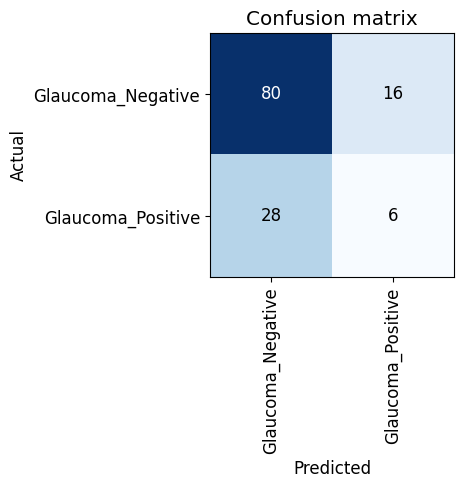

In [ ]:
# Interpret and visualize the model's performance with the new configuration

interp2 = ClassificationInterpretation.from_learner(learn2)
interp2.plot_confusion_matrix()  # Plot the confusion matrix